In [1]:
from src.Distributions import *
from collections import Counter
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter, ScalarFormatter, LogLocator, LogFormatterSciNotation
import matplotlib.lines as mlines
from itertools import cycle
from IPython.display import clear_output
plt.style.use('properties.mplstyle')

In [2]:
N = 10**5
# Generate .npy with all degree and distances values from gml.gz files
degree_file(N)
distance_file(N)
clear_output()

In [ ]:
alpha_ag_f = 2.0
alpha_g_v = [i for i in np.arange(1.0, 10.0, 0.5)]
alpha_a_v = [i for i in np.arange(2.0, 10.0, 0.5)]
dim = [1,2,3,4]
# Generate .npy with all degree values from gml.gz files
bin_count = 80
for d in dim:
    for aa in alpha_a_v:
        # Generate log_binning file to distances and degree
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_ag_f}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_ag_f:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_ag_f, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_ag_f:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_ag_f, propertie="degree")

        # Generate linear binning to degree
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_ag_f, propertie="degree")
    
    print("-----------------")
    for ag in alpha_g_v:
        # Generate log_binning file to distances and degree
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_ag_f}, alpha_g = {ag}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{ag:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_ag_f, alpha_g=ag, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{ag:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_ag_f, alpha_g=ag, propertie="degree")

        # Generate linear binning to degree
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=alpha_ag_f, alpha_g=ag, propertie="degree")

N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/degree_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 2.5, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.50_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.50_alpha_g_2.00/degree_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.50_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 3.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_3.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_3.00_alpha_g_2.00/degree_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_3.00_alp

In [2]:
N = 10**5
dim = [1, 2, 3, 4]
alpha_g_v = np.arange(1.0, 10, 0.5)
alpha_a_v = np.arange(2.0, 10, 0.5)
save_json_distributions(N, dim, alpha_a_v, alpha_g_v)

Arquivo '../../data/distances_distributions.json' salvo com sucesso.
Arquivo '../../data/degree_distributions.json' salvo com sucesso.


In [3]:
# read json of degree and converter to DataFrame Pandas
df_degree = json_to_dataframe_with_lists('../../data/degree_distributions.json')
# read json of degree and converter to DataFrame Pandas
df_distances = json_to_dataframe_with_lists('../../data/distances_distributions.json')
df_degree.head()

,N,alpha_A,alpha_G,dim,N_s,k,Pk
0,100000,2.0,1.0,1,288,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[0.570086076388889, 0.2080551041666667, 0.0962..."
1,100000,2.0,1.5,1,19,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]","[0.1093880180850709, 0.1126762127995201, 0.111..."
2,100000,2.0,2.0,1,1309,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[0.5700415049656227, 0.2080716883116883, 0.096..."
3,100000,2.0,2.5,1,20,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]","[0.1093880180850709, 0.1126762127995201, 0.111..."
4,100000,2.0,3.0,1,539,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[0.5694902691415848, 0.2080788569104833, 0.096..."


In [7]:
np.sort(df_degree[df_degree["alpha_G"]==2.0]["alpha_A"].unique())

array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ,
       8.5, 9. , 9.5])

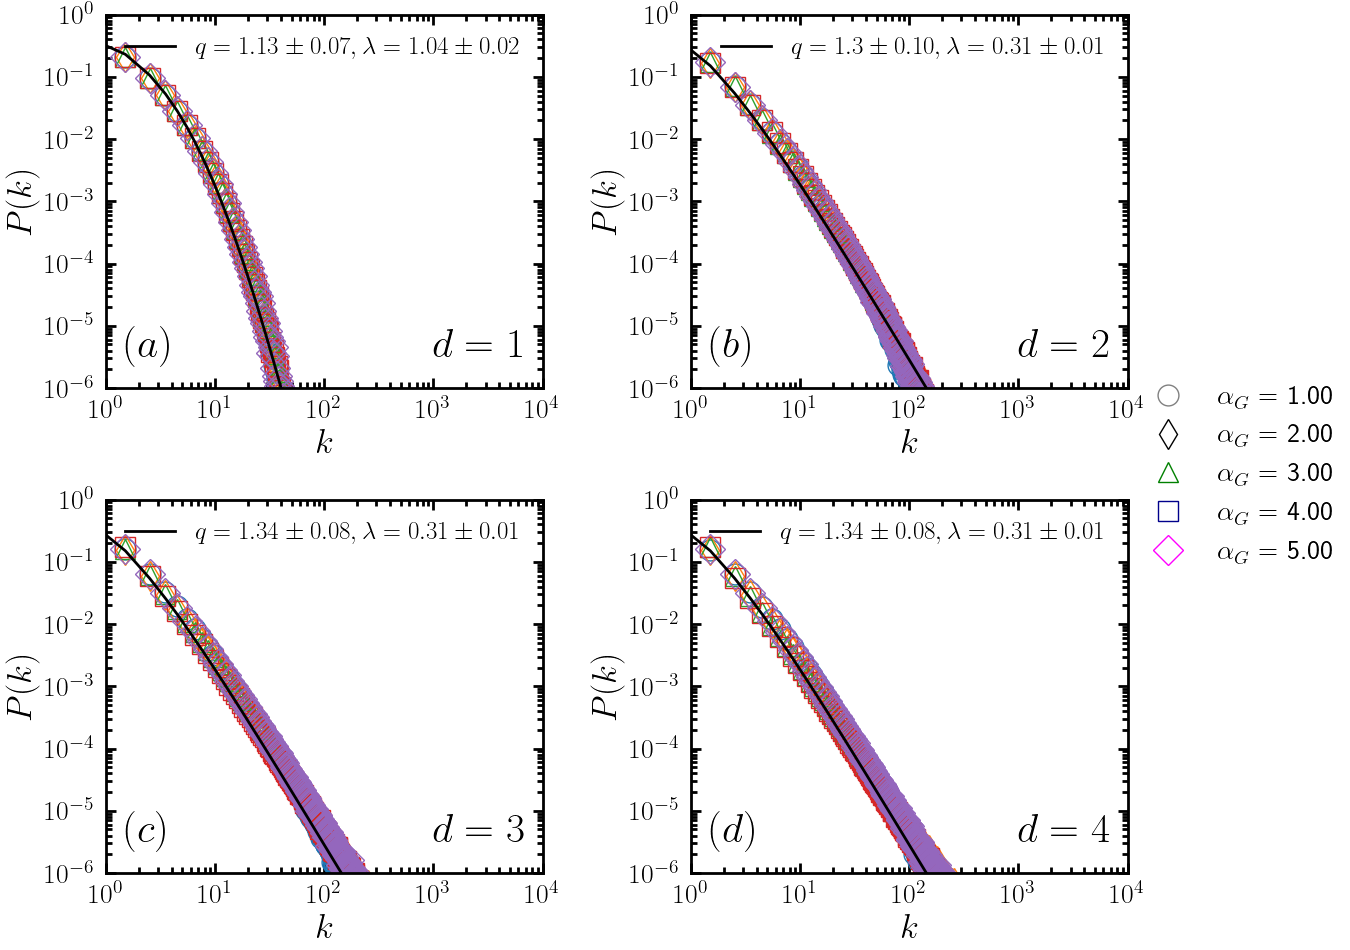

In [4]:
# ✔️ Definindo manualmente os parâmetros
alpha_ag_f = 2.0
alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0]
alpha_a_v = [0.0, 1.0, 2.0, 4.0, 6.0, 8.0]
dim_list = [1,2,3,4]

# Alpha_A fixo em 2.0, Alpha_G variando
k_1d_g, pk_1d_g = get_k_pk_from_dataframe(df_degree, dim=1, fixed_param='alpha_A', fixed_value=2.0, varying_param_list=alpha_g_v)
k_2d_g, pk_2d_g = get_k_pk_from_dataframe(df_degree, dim=2, fixed_param='alpha_A', fixed_value=2.0, varying_param_list=alpha_g_v)
k_3d_g, pk_3d_g = get_k_pk_from_dataframe(df_degree, dim=3, fixed_param='alpha_A', fixed_value=2.0, varying_param_list=alpha_g_v)
k_4d_g, pk_4d_g = get_k_pk_from_dataframe(df_degree, dim=4, fixed_param='alpha_A', fixed_value=2.0, varying_param_list=alpha_g_v)

q_1d, err_1d_q, b_1d, err_1d_b = combine_estimates_from_datasets(k_1d_g, pk_1d_g, dim = 1)
q_2d, err_2d_q ,b_2d, err_2d_b = combine_estimates_from_datasets(k_2d_g, pk_2d_g, dim = 2)
q_3d, err_3d_q, b_3d, err_3d_b = combine_estimates_from_datasets(k_3d_g, pk_3d_g, dim = 3)
q_4d, err_4d_q, b_4d, err_4d_b = combine_estimates_from_datasets(k_4d_g, pk_4d_g, dim = 4)

Q, Q_err, B, B_err = [q_1d, q_2d, q_3d, q_4d], [err_1d_q, err_2d_q, err_3d_q, err_4d_q], [b_1d, b_2d, b_3d, b_4d], [err_1d_b, err_2d_b, err_3d_b, err_4d_b]


# ✔️ Ler os JSONs convertidos em DataFrames
df_degree = json_to_dataframe_with_lists('../../data/degree_distributions.json')
df_distances = json_to_dataframe_with_lists('../../data/distances_distributions.json')

label_1d = f'$q =  {q_1d:.2f} \\pm {err_1d_q:.2f}, \\lambda = {b_1d:.2f} \\pm {err_1d_b:.2f}$'
label_2d = f'$q = {q_2d:.1f} \\pm {err_2d_q:.2f}, \\lambda = {b_2d:.2f} \\pm {err_2d_b:.2f}$'
label_3d = f'$q = {q_3d:.2f} \\pm {err_3d_q:.2f}, \\lambda = {b_3d:.2f} \\pm {err_3d_b:.2f}$'
label_4d = f'$q = {q_4d:.2f} \\pm {err_4d_q:.2f}, \\lambda = {b_4d:.2f} \\pm {err_4d_b:.2f}$'
labels = [label_1d, label_2d, label_3d, label_4d]

labels_tick = ["$(a)$", "$(b)$", "$(c)$", "$(d)$"]

# ✔️ Filtrar os dados para conter apenas os valores desejados
df_degree_filter = df_degree[
    (df_degree['alpha_A'].isin([2.0])) &  # para alpha_G variando, alpha_A fixo
    (df_degree['alpha_G'].isin(alpha_g_v))
]

# ✔️ Configurações visuais
color = ["#808080", "black", '#008000', "#00008B", "magenta", "darkgoldenrod"]
markers = ["o", "d", "^", "s", "D", "v", "<", ">", "p", "*"]
markersize = 15

labels_global = [rf"$\alpha_G$ = {a:.2f}" for a in alpha_g_v]
titles = [f"$d = {d}$" for d in dim_list]
thickness_axes = 2.0

# ✔️ Criando os subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# ✔️ Loop nas dimensões
for idx, d in enumerate(dim_list):
    row, col = divmod(idx, 2)
    df_dim = df_degree_filter[df_degree_filter['dim'] == d]

    for i, alpha_g in enumerate(alpha_g_v):
        df_alpha = df_dim[df_dim['alpha_G'] == alpha_g]

        if not df_alpha.empty:
            k = df_alpha['k'].iloc[0]
            pk = df_alpha['Pk'].iloc[0]
            ax[row, col].plot(
                k, pk,
                markers[i % len(markers)],  # segurança contra estouro de índice
                markersize=markersize, mew=1.0,
                label="_nolegend_"
            )
    df_alpha = df_dim[df_dim['alpha_G'] == 1.0]
    
    ax[row, col].plot(df_alpha['k'].iloc[0], q_exp(df_alpha['k'].iloc[0],Q[idx],B[idx]), linewidth=thickness_axes, color='k', label=labels[idx])
    
    ax[row, col].text(1.5, 10**(-5.5), labels_tick[idx], style="normal", fontsize=30)
    ax[row, col].text(10**(3.0), 10**(-5.5), f"$d = {d}$", style="normal", fontsize=30)
    # ✔️ Configurações dos eixos
    ax[row, col].set_xscale('log')
    ax[row, col].set_yscale('log')
    ax[row, col].set_xlim([1, 1e4])
    ax[row, col].set_ylim([1e-6, 1])
    ax[row, col].set_ylabel(r"$P(k)$", size=25)
    ax[row, col].set_xlabel(r"$k$", size=25)

    # ✔️ Configuração de ticks e escalas
    ax[row, col].tick_params(axis='both', which='major', direction='in', length=7, width=2, labelsize=20)
    ax[row, col].tick_params(axis='both', which='minor', direction='in', length=4, width=2)

    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax[row, col].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))

    ax[row, col].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))
    ax[row, col].yaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))
    
    ax[row, col].legend(prop={"size":18}, fancybox=True, framealpha=0.0)
    
    for spine in ax[row, col].spines.values():
        spine.set_linewidth(thickness_axes)

# ✔️ Legenda global
proxy_handles = [
    plt.Line2D([], [], color=color[i % len(color)], marker=markers[i % len(markers)], linestyle='None',
               markersize=markersize, markerfacecolor='none', mew=1.0)
    for i in range(len(alpha_g_v))
]
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.76, 0.5),
           fontsize=20, frameon=False)

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig("../../results/distributions/degree_alpha_g.png", dpi=300)
plt.show()


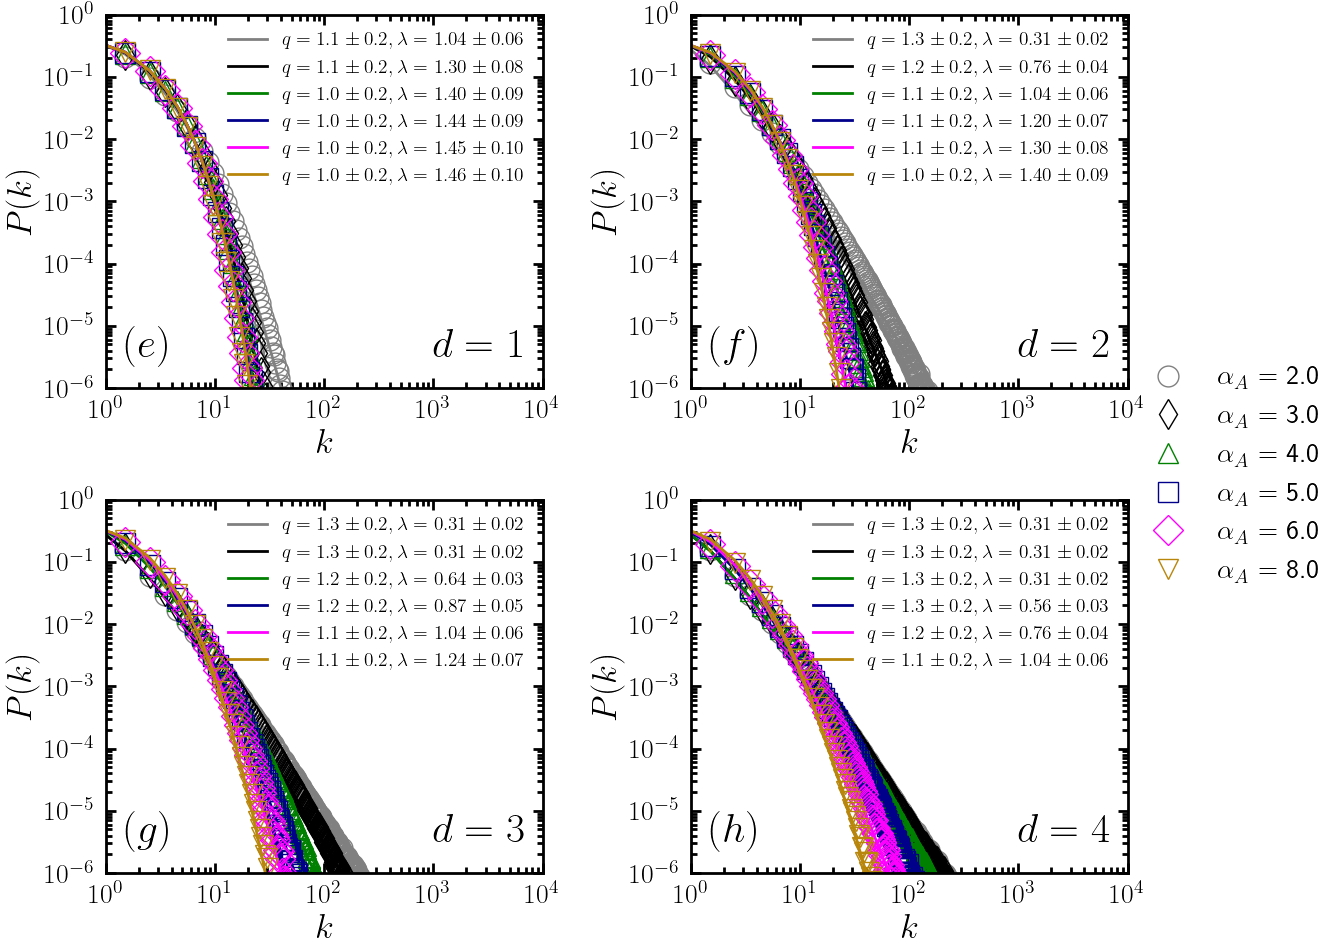

In [ ]:
# ✔️ Criando subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
alpha_ag_f = 2.0

alpha_a = [2.0, 3.0, 4.0, 6.0, 8.0]

# ✔️ Filtrar para alpha_G fixo e alpha_A variando
df_degree_filter = df_degree[
    (df_degree['alpha_G'] == alpha_ag_f) &
    (df_degree['alpha_A'].isin(alpha_a_v))
]


# ✔️ Configurações visuais
color = ["#808080", "black", '#008000', "#00008B", "magenta", "darkgoldenrod"]
markers = ["o", "d", "^", "s", "D", "v"]
markersize = 15
thickness_axes = 2.0

labels_global = [rf"$\alpha_A$ = {a:.1f}" for a in alpha_a_v]
titles = [f"$d = {d}$" for d in dim_list]
labels_tick = ["$(e)$", "$(f)$", "$(g)$", "$(h)$"]

# ✔️ Inicializando listas para parâmetros e legendas
Q_1d, B_1d = [], []
Q_2d, B_2d = [], []
Q_3d, B_3d = [], []
Q_4d, B_4d = [], []

legend_1d_alpha_a = []
legend_2d_alpha_a = []
legend_3d_alpha_a = []
legend_4d_alpha_a = []

for idx, d in enumerate(dim_list):
    row, col = divmod(idx, 2)
    df_dim = df_degree_filter[df_degree_filter['dim'] == d]

    for i, alpha_a in enumerate(alpha_a_v):
        df_alpha = df_dim[df_dim['alpha_A'] == alpha_a]

        if not df_alpha.empty:
            k = df_alpha['k'].iloc[0]
            pk = df_alpha['Pk'].iloc[0]

            # ✔️ Ajuste dos parâmetros q e lambda
            fitted_q, fitted_b, perr_q, perr_b = optimize_q_exp(
                k, pk,
                q_initial=q(alpha_a, d),
                b_initial=eta(alpha_a, d),
                delta_q=0.01,
                delta_b=0.01
            )

            # ✔️ Plot dados empíricos
            ax[row, col].plot(
                k, pk,
                marker=markers[i % len(markers)],
                color=color[i % len(color)],
                markersize=markersize,
                linestyle='None',
                markerfacecolor='none',
                mew=1.0,
                label="_nolegend_"
            )

            # ✔️ Plot curva ajustada
            ax[row, col].plot(
                k, q_exp(k, fitted_q, fitted_b),
                color=color[i % len(color)],
                linewidth=thickness_axes,
                label = f"$q = {round_measurement(fitted_q, perr_q)}, \\lambda = {round_measurement(fitted_b, perr_b)}$"
            )

    # ✔️ Texto dos subplots
    ax[row, col].text(1.5, 10**(-5.5), labels_tick[idx], style="normal", fontsize=30)
    ax[row, col].text(10**(3.0), 10**(-5.5), f"$d = {d}$", style="normal", fontsize=30)

    # ✔️ Configurações dos eixos
    ax[row, col].set_xscale('log')
    ax[row, col].set_yscale('log')
    ax[row, col].set_xlim([1, 1e4])
    ax[row, col].set_ylim([1e-6, 1])
    ax[row, col].set_ylabel(r"$P(k)$", size=25)
    ax[row, col].set_xlabel(r"$k$", size=25)

    ax[row, col].tick_params(axis='both', which='major', direction='in', length=7, width=2, labelsize=20)
    ax[row, col].tick_params(axis='both', which='minor', direction='in', length=4, width=2)

    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax[row, col].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))

    ax[row, col].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))
    ax[row, col].yaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))

    ax[row, col].legend(prop={"size":14}, fancybox=True, framealpha=0.0)

    for spine in ax[row, col].spines.values():
        spine.set_linewidth(thickness_axes)


# ✔️ Legenda global dos dados empíricos
proxy_handles = [
    plt.Line2D([], [], color=color[i % len(color)], marker=markers[i % len(markers)], linestyle='None',
               markersize=markersize, markerfacecolor='none', mew=1.0)
    for i in range(len(alpha_a_v))
]
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.76, 0.5),
           fontsize=20, frameon=False)

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig("../../results/distributions/degree_alpha_a.png", dpi=300)
plt.show()

In [37]:
alpha_a_v = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [38]:
k_1d_g, pk_1d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g, pk_2d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g, pk_3d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g, pk_4d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a, pk_1d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a, pk_2d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a, pk_3d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a, pk_4d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [39]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')

    k_1d_g[i], pk_1d_g[i] = df_1d["ds"], df_1d["pds"]
    k_2d_g[i], pk_2d_g[i] = df_2d["ds"], df_2d["pds"]
    k_3d_g[i], pk_3d_g[i] = df_3d["ds"], df_3d["pds"]
    k_4d_g[i], pk_4d_g[i] = df_4d["ds"], df_4d["pds"]

In [40]:
for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances_distribution_log.csv", delimiter=' ')

        k_1d_a[i], pk_1d_a[i] = df_1d["ds"], df_1d["pds"]
        k_2d_a[i], pk_2d_a[i] = df_2d["ds"], df_2d["pds"]
        k_3d_a[i], pk_3d_a[i] = df_3d["ds"], df_3d["pds"]
        k_4d_a[i], pk_4d_a[i] = df_4d["ds"], df_4d["pds"]

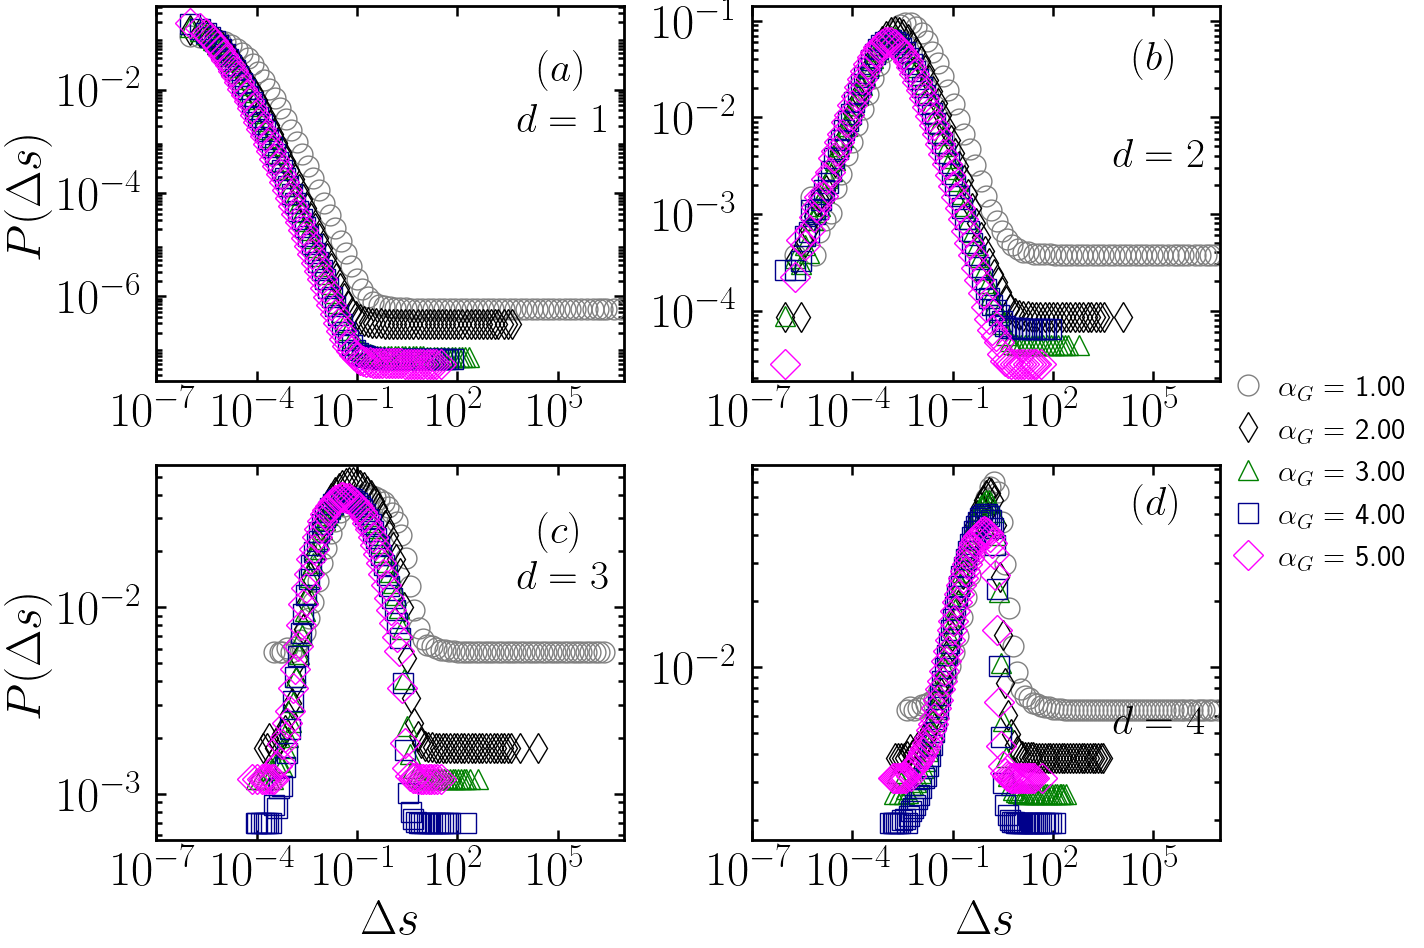

In [42]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]
markers = ["o","d","^","s","D", "*"]
#markers = ["o","o","o","o","o"]
labels_global = [rf"$\alpha_G$ = {i:.2f}" for i in alpha_g_v]
markersize = 15
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_g_v)):
    kwargs = dict(
        marker=markers[i],
        markersize=markersize,
        linestyle='None',
        markerfacecolor='none',     # vazio por dentro
        markeredgecolor=color[i],   # cor do contorno
        markeredgewidth=1.0
    )
    ax[0,0].plot(k_1d_g[i], pk_1d_g[i], **kwargs)
    ax[0,1].plot(k_2d_g[i], pk_2d_g[i], **kwargs)
    ax[1,0].plot(k_3d_g[i], pk_3d_g[i], **kwargs)
    ax[1,1].plot(k_4d_g[i], pk_4d_g[i], **kwargs)
    
thickness_axes =  2.4
parts_of_graphic = ['top', 'bottom', 'left', 'right']
proxy_handles = [
    plt.Line2D(
        [], [],
        linestyle='None',
        marker=markers[i],
        markersize=markersize,
        markerfacecolor='none',
        markeredgecolor=color[i],
        markeredgewidth=1.0
    )
    for i in range(len(alpha_g_v))
]
fig.legend(proxy_handles, labels_global,
           loc="center left", bbox_to_anchor=(0.81, 0.5),handletextpad=.001 ,
           fontsize=22, frameon=False)


# for f, d in zip(ax.flatten(), dim):
#     f.set_title(f"$d = {d}$")

ax[0, 0].text(10**4.4, 10**(-1.8), "$(a)$", style="normal" ,fontsize=30)
ax[0, 1].text(10**4.4, 10**(-1.5), "$(b)$", style="normal" ,fontsize=30)
ax[1, 0].text(10**4.4, 10**(-1.65), "$(c)$", style="normal" ,fontsize=30)
ax[1, 1].text(10**4.4, 10**(-1.3), "$(d)$", style="normal" ,fontsize=30)


ax[0, 0].text(10**(3.8), 10**(-2.8), f'$d = 1$', style="normal" ,fontsize=30)
ax[0, 1].text(10**(3.8), 10**(-2.5), f'$d = 2$', style="normal" ,fontsize=30)
ax[1, 0].text(10**(3.8), 10**(-1.9), f'$d = 3$', style="normal" ,fontsize=30)
ax[1, 1].text(10**(3.8), 10**(-2.3), f'$d = 4$', style="normal" ,fontsize=30)

thickness_axes = 2.0

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([10**(-7),10**7])
        #ax[i, j].set_ylim([10**(-7),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$", fontsize = 35)
        ax[1, j].set_xlabel(r"$\Delta s$", fontsize = 35)
        
        for spine in ax[i, j].spines.values():
            spine.set_linewidth(thickness_axes)
        ax[i, j].xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
        ax[i, j].yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
        ax[i, j].tick_params(axis='both', which='major', direction='in', length=7, width=1.8, colors='black')
        ax[i, j].tick_params(axis='both', which='minor', direction='in', length=4, width=1.8, colors='black')
        ax[i, j].tick_params('both', labelsize=35)
        # Subticks automáticos entre potências de 10
        ax[i, j].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
        ax[i, j].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))

        # Formatação dos ticks como 10⁰, 10¹, ...
        ax[i, j].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))
        ax[i, j].yaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))        

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_g_N100000.svg", dpi =300)
plt.show()

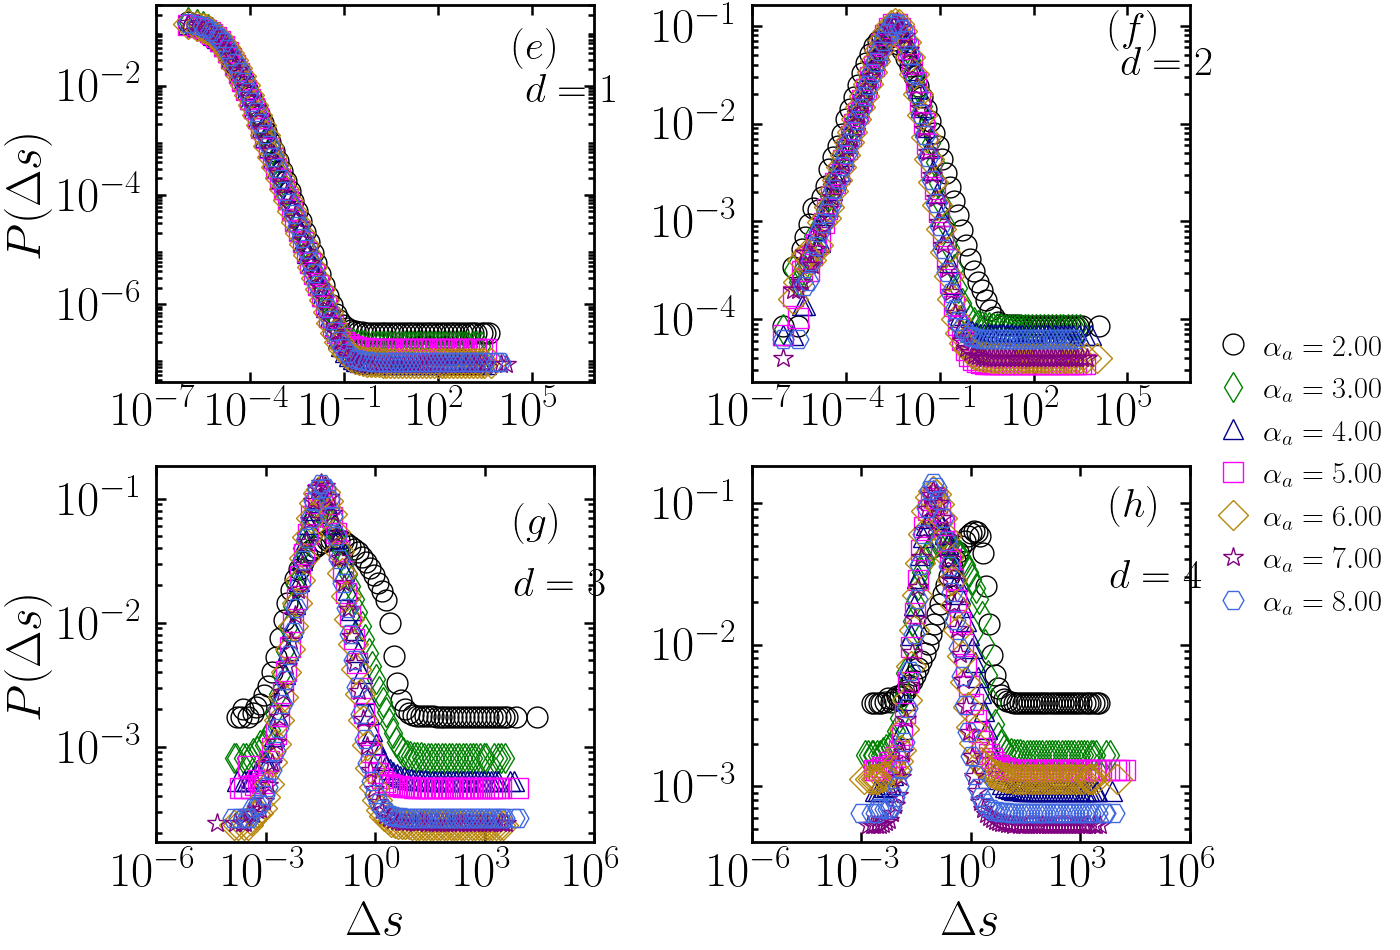

In [43]:
color = ["black",'#008000',"#00008B","magenta","darkgoldenrod","purple","royalblue", "silver"]

markers = ["o","d","^","s","D","*","H","p","P"]
labels_global = [rf"$\alpha_a = {alpha_a_v[i]:.2f}$" for i in range(len(alpha_a_v))]
#markers = ["o","o","o","o","o"]
labels_1 = [rf"$\alpha_A = {alpha_a_v[i]:.2f}$" for i in range(len(alpha_a_v))]
markersize = 15
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_a_v)):
    kwargs = dict(
        marker=markers[i],
        markersize=markersize,
        linestyle='None',
        markerfacecolor='none',     # vazio por dentro
        markeredgecolor=color[i],   # cor do contorno
        markeredgewidth=1.0
    )
    ax[0,0].plot(k_1d_a[i], pk_1d_a[i], **kwargs)
    ax[0,1].plot(k_2d_a[i], pk_2d_a[i], **kwargs)
    ax[1,0].plot(k_3d_a[i], pk_3d_a[i], **kwargs)
    ax[1,1].plot(k_4d_a[i], pk_4d_a[i], **kwargs)


thickness_axes =  2.0
# Criando proxies para a legenda global (α_a)
proxy_handles = [
    plt.Line2D(
        [], [],
        linestyle='None',
        marker=markers[i],
        markersize=markersize,
        markerfacecolor='none',
        markeredgecolor=color[i],
        markeredgewidth=1.0
    )
    for i in range(len(alpha_a_v))
]
fig.legend(proxy_handles, labels_global,
           loc="center left", bbox_to_anchor=(0.80, 0.5), handletextpad=.001,
           fontsize=22, frameon=False)



ax[0, 0].text(10**(4.4), 10**(-1.5), "$(e)$", style="normal" ,fontsize=30)
ax[0, 1].text(10**(4.4), 10**(-1.15), "$(f)$", style="normal" ,fontsize=30)
ax[1, 0].text(10**3.8, 10**(-1.28), "$(g)$", style="normal" ,fontsize=30)
ax[1, 1].text(10**3.8, 10**(-1.10), "$(h)$", style="normal" ,fontsize=30)


ax[0, 0].text(10**4.8, 10**(-2.3), f'$d = 1$', style="normal" ,fontsize=30)
ax[0, 1].text(10**4.8, 10**(-1.50), f'$d = 2$', style="normal" ,fontsize=30)
ax[1, 0].text(10**3.8, 10**(-1.78), f'$d = 3$', style="normal" ,fontsize=30)
ax[1, 1].text(10**3.8, 10**(-1.60), f'$d = 4$', style="normal" ,fontsize=30)
# for f, d in zip(ax.flatten(), dim):
#     f.set_title(f"$d = {d}$", fontsize=18)

parts_of_graphic = ['top', 'bottom', 'left', 'right']
for i in range(2):
    for j in range(2):
        if(i == 0):
            ax[i, j].set_xlim([10**(-7),10**7])
#            ax[i, j].set_ylim([10**(-8),10**0])
        else:
            ax[i, j].set_xlim([10**(-6),10**6])
            
        
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$", fontsize=35)
        ax[1, j].set_xlabel(r"$\Delta s$", fontsize=35)

        ax[i, j].tick_params(axis='both', which='major', direction='in', length=7, width=1.8, colors='black')
        ax[i, j].tick_params(axis='both', which='minor', direction='in', length=4, width=1.8, colors='black')
        ax[i, j].tick_params('both', labelsize=35)
        for spine in ax[i, j].spines.values():
            spine.set_linewidth(thickness_axes)
        ax[i, j].xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
        ax[i, j].yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
        
        # Subticks automáticos entre potências de 10
        ax[i, j].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
        ax[i, j].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))

        # Formatação dos ticks como 10⁰, 10¹, ...
        ax[i, j].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))
        ax[i, j].yaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))
        
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_a_N100000.svg", dpi =300)
plt.show()

In [10]:
N = 10**5
dim = [1,2,3,4]
alpha_ag_f = 2.0
alpha_a_v = [i for i in np.arange(2.0, 10, 0.5)]
alpha_g_v = [i for i in np.arange(1.0, 10, 0.5)]
# Generate .npy with all degree values from gml.gz files
bin_count = 80
# for d in dim:
#     for aa in alpha_a_v:
#         # Generate log_binning file to distances and degree
#         print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_ag_f}")
#         dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_ag_f:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
#         dados_flat = dados.flatten()
#         log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_ag_f, propertie="distances")

for d in dim:
    for ag in alpha_g_v:
        # Generate log_binning file to distances and degree
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_ag_f}, alpha_g = {ag}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{ag:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_ag_f, alpha_g=ag, propertie="distances")

N = 100000, dim = 1, alpha_a = 1.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_1.00/distances_distribution_log.csv
N = 100000, dim = 1, alpha_a = 1.5, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_1.50/distances_distribution_log.csv
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/distances_distribution_log.csv
N = 100000, dim = 1, alpha_a = 2.5, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.50/distances_distribution_log.csv
N = 100000, dim = 1, alpha_a = 3.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_3.00/distances_distribution_log.csv
N = 100000, dim = 1, alpha_a = 3.5, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_3.50/distances_distribution_log.csv
N = 100000, dim = 1, alpha_a = 4.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a

In [21]:
N, d, alpha_ag_f, ag = 10**5, 1, 2.0, 2.0
dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{ag:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
dados_flat = dados.flatten()
int(len(dados_flat)/N)

1047

In [ ]:
N = 10**5
dim = [1,2,3,4]
alpha_ag_f = 2.0
alpha_g_v = [i for i in np.arange(1.0, 10, 0.5)]
alpha_a_v = [i for i in np.arange(2.0, 10, 0.5)]


for d in dim:
    for i in range(len(alpha_g_v)):
        df_ = pd.read_csv(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        N_s = int(len(dados_flat)/N)
        k, pk = df_["ds"], df_["pds"]
    
    for j in range(len(alpha_a_v)):
        df_ = pd.read_csv(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        N_s = int(len(dados_flat)/N)
        k, pk = df_["ds"], df_["pds"]
        #df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
        #df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
        #df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')

        #k_1d_g[i], pk_1d_g[i] = df_1d["ds"], df_1d["pds"]
        #k_2d_g[i], pk_2d_g[i] = df_2d["ds"], df_2d["pds"]
        #k_3d_g[i], pk_3d_g[i] = df_3d["ds"], df_3d["pds"]
        #k_4d_g[i], pk_4d_g[i] = df_4d["ds"], df_4d["pds"]
for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_ag_f:.2f}/distances_distribution_log.csv", delimiter=' ')

        k_1d_a[i], pk_1d_a[i] = df_1d["ds"], df_1d["pds"]
        k_2d_a[i], pk_2d_a[i] = df_2d["ds"], df_2d["pds"]
        k_3d_a[i], pk_3d_a[i] = df_3d["ds"], df_3d["pds"]
        k_4d_a[i], pk_4d_a[i] = df_4d["ds"], df_4d["pds"]

In [36]:
import numpy as np
import pandas as pd
import json
import os

N = 10**5
dim = [1, 2, 3, 4]
alpha_ag_f = 2.0
alpha_g_v = np.arange(1.0, 10, 0.5)
alpha_a_v = np.arange(2.0, 10, 0.5)


def distances_distribution(N, dim, alpha_a_v, alpha_g_v):
    alpha_ag_f = 2.0
    data = []
    
    for d in dim:
        # Loop variando alpha_g
        for alpha_g in alpha_g_v:
            folder = f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g:.2f}"
            try:
                df = pd.read_csv(os.path.join(folder, "distances_distribution_log.csv"), delimiter=' ')
                dados = np.load(os.path.join(folder, "distances.npy"))
            except Exception as e:
                print(f"Erro ao ler {folder}: {e}")
                continue

            N_s = int(dados.size / N)

            entry = {
                "N": N,
                "alpha_A": format(alpha_ag_f, '.2f'),
                "alpha_G": format(alpha_g, '.2f'),
                "dim": d,
                "N_s": N_s,
                "k": df["ds"].tolist(),
                "Pk": df["pds"].tolist()
            }
            data.append(entry)

        # Loop variando alpha_a
        for alpha_a in alpha_a_v:
            folder = f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a:.2f}_alpha_g_{alpha_ag_f:.2f}"
            try:
                df = pd.read_csv(os.path.join(folder, "distances_distribution_log.csv"), delimiter=' ')
                dados = np.load(os.path.join(folder, "distances.npy"))
            except Exception as e:
                print(f"Erro ao ler {folder}: {e}")
                continue

            N_s = int(dados.size / N)

            entry = {
                "N": N,
                "alpha_A": format(alpha_a,'.2f'),
                "alpha_G": format(alpha_ag_f,'.2f'),
                "dim": d,
                "N_s": N_s,
                "k": df["ds"].tolist(),
                "Pk": df["pds"].tolist()
            }
            data.append(entry)

    # Salvar como JSON
    with open('../../data/distances_distributions.json', 'w') as f:
        json.dump(data, f, indent=4)

    print("Arquivo salvo como 'distances_distributions.json'")
distances_distribution(N, dim, alpha_a_v, alpha_g_v)

Arquivo salvo como 'distances_distributions.json'


In [ ]:
import numpy as np
import pandas as pd
import json
import os


def generate_distributions(N, dim, alpha_a_v, alpha_g_v):
    alpha_ag_f = 2.0

    # Dicionários para armazenar dados separados
    data_distance = []
    data_degree = []

    types = [
        {
            "name": "distance",
            "csv_name": "distances_distribution_log.csv",
            "npy_name": "distances.npy",
            "csv_columns": ["ds", "pds"],
            "data_list": data_distance,
            "output_path": '../../data/distances_distributions.json'
        },
        {
            "name": "degree",
            "csv_name": "filenames_degree.csv",
            "npy_name": "degree.npy",
            "csv_columns": ["k", "pk"],
            "data_list": data_degree,
            "output_path": '../../data/degree_distributions.json'
        }
    ]

    for d in dim:
        for t in types:
            # Loop variando alpha_g
            for alpha_g in alpha_g_v:
                folder = f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{alpha_g:.2f}"
                try:
                    df = pd.read_csv(os.path.join(folder, t["csv_name"]), delimiter=' ')
                    dados = np.load(os.path.join(folder, t["npy_name"]))
                except Exception as e:
                    print(f"Erro ao ler {folder} ({t['name']}): {e}")
                    continue

                N_s = int(dados.size / N)

                entry = {
                    "N": N,
                    "alpha_A": round(alpha_ag_f, 2),
                    "alpha_G": round(alpha_g, 2),
                    "dim": d,
                    "N_s": N_s,
                    "k": df[t["csv_columns"][0]].tolist(),
                    "Pk": df[t["csv_columns"][1]].tolist()
                }
                t["data_list"].append(entry)

            # Loop variando alpha_a
            for alpha_a in alpha_a_v:
                folder = f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a:.2f}_alpha_g_{alpha_ag_f:.2f}"
                try:
                    df = pd.read_csv(os.path.join(folder, t["csv_name"]), delimiter=' ')
                    dados = np.load(os.path.join(folder, t["npy_name"]))
                except Exception as e:
                    print(f"Erro ao ler {folder} ({t['name']}): {e}")
                    continue

                N_s = int(dados.size / N)

                entry = {
                    "N": N,
                    "alpha_A": round(alpha_a, 2),
                    "alpha_G": round(alpha_ag_f, 2),
                    "dim": d,
                    "N_s": N_s,
                    "k": df[t["csv_columns"][0]].tolist(),
                    "Pk": df[t["csv_columns"][1]].tolist()
                }
                t["data_list"].append(entry)

    # Salvar os arquivos separados
    for t in types:
        with open(t["output_path"], 'w') as f:
            json.dump(t["data_list"], f, indent=4)
        print(f"Arquivo '{t['output_path']}' salvo com sucesso.")

N = 10**5
dim = [1, 2, 3, 4]
alpha_ag_f = 2.0
alpha_g_v = np.arange(1.0, 10, 0.5)
alpha_a_v = np.arange(2.0, 10, 0.5)
generate_distributions(N, dim, alpha_a_v, alpha_g_v)

KeyError: 'k'

In [12]:
min_k_2d_ag, min_pk_2d_ag = [], []
min_k_3d_ag, min_pk_3d_ag = [], []
min_k_4d_ag, min_pk_4d_ag = [], []

df_k_max_alpha_g = {"alpha_g":[], "k_2d":[],"k_3d":[], "k_3d":[]}
df_pk_max_alpha_g = {"alpha_g":[],"pk_2d":[],"pk_3d":[], "pk_3d":[]}

dimensions = [1,2,3,4]

for i in range(len(alpha_g_v)):
    k_2d_ag, pk_2d_ag = k_2d_g[i], pk_2d_g[i]
    k_3d_ag, pk_3d_ag = k_3d_g[i], pk_3d_g[i]
    k_4d_ag, pk_4d_ag = k_4d_g[i], pk_4d_g[i]
    
    k_min_2d_ag = [k_2d_ag[idx] for idx, ele in enumerate(zip(k_2d_ag, pk_2d_ag)) if ele[1] == max(pk_2d_ag)][0]
    k_min_3d_ag = [k_3d_ag[idx] for idx, ele in enumerate(zip(k_3d_ag, pk_3d_ag)) if ele[1] == max(pk_3d_ag)][0]
    k_min_4d_ag = [k_4d_ag[idx] for idx, ele in enumerate(zip(k_4d_ag, pk_4d_ag)) if ele[1] == max(pk_4d_ag)][0]
    
    min_k_2d_ag.append(k_min_2d_ag)
    min_pk_2d_ag.append(max(pk_2d_ag))

    min_k_3d_ag.append(k_min_3d_ag)
    min_pk_3d_ag.append(max(pk_3d_ag))

    min_k_4d_ag.append(k_min_4d_ag)
    min_pk_4d_ag.append(max(pk_4d_ag))

df_k_max_alpha_g["alpha_g"] = alpha_g_v
df_k_max_alpha_g["k_2d"] = min_k_2d_ag
df_k_max_alpha_g["k_3d"] = min_k_3d_ag
df_k_max_alpha_g["k_4d"] = min_k_4d_ag

df_pk_max_alpha_g["alpha_g"] = alpha_g_v
df_pk_max_alpha_g["pk_2d"] = min_pk_2d_ag
df_pk_max_alpha_g["pk_3d"] = min_pk_3d_ag
df_pk_max_alpha_g["pk_4d"] = min_pk_4d_ag

In [13]:
min_k_2d_aa, min_pk_2d_aa = [], []
min_k_3d_aa, min_pk_3d_aa = [], []
min_k_4d_aa, min_pk_4d_aa = [], []

df_k_max_alpha_a = {"alpha_a":[], "k_2d":[],"k_3d":[], "k_3d":[]}
df_pk_max_alpha_a = {"alpha_a":[],"pk_2d":[],"pk_3d":[], "pk_3d":[]}

dimensions = [1,2,3,4]

for i in range(len(alpha_a_v)):
    k_2d_aa, pk_2d_aa = k_2d_a[i], pk_2d_a[i]
    k_3d_aa, pk_3d_aa = k_3d_a[i], pk_3d_a[i]
    k_4d_aa, pk_4d_aa = k_4d_a[i], pk_4d_a[i]
    
    k_min_2d_aa = [k_2d_aa[idx] for idx, ele in enumerate(zip(k_2d_aa, pk_2d_aa)) if ele[1] == max(pk_2d_aa)][0]
    k_min_3d_aa = [k_3d_aa[idx] for idx, ele in enumerate(zip(k_3d_aa, pk_3d_aa)) if ele[1] == max(pk_3d_aa)][0]
    k_min_4d_aa = [k_4d_aa[idx] for idx, ele in enumerate(zip(k_4d_aa, pk_4d_aa)) if ele[1] == max(pk_4d_aa)][0]
    
    min_k_2d_aa.append(k_min_2d_aa)
    min_pk_2d_aa.append(max(pk_2d_aa))

    min_k_3d_aa.append(k_min_3d_aa)
    min_pk_3d_aa.append(max(pk_3d_aa))

    min_k_4d_aa.append(k_min_4d_aa)
    min_pk_4d_aa.append(max(pk_4d_aa))

df_k_max_alpha_a["alpha_a"] = alpha_a_v
df_k_max_alpha_a["k_2d"] = min_k_2d_aa
df_k_max_alpha_a["k_3d"] = min_k_3d_aa
df_k_max_alpha_a["k_4d"] = min_k_4d_aa

df_pk_max_alpha_a["alpha_a"] = alpha_a_v
df_pk_max_alpha_a["pk_2d"] = min_pk_2d_aa
df_pk_max_alpha_a["pk_3d"] = min_pk_3d_aa
df_pk_max_alpha_a["pk_4d"] = min_pk_4d_aa

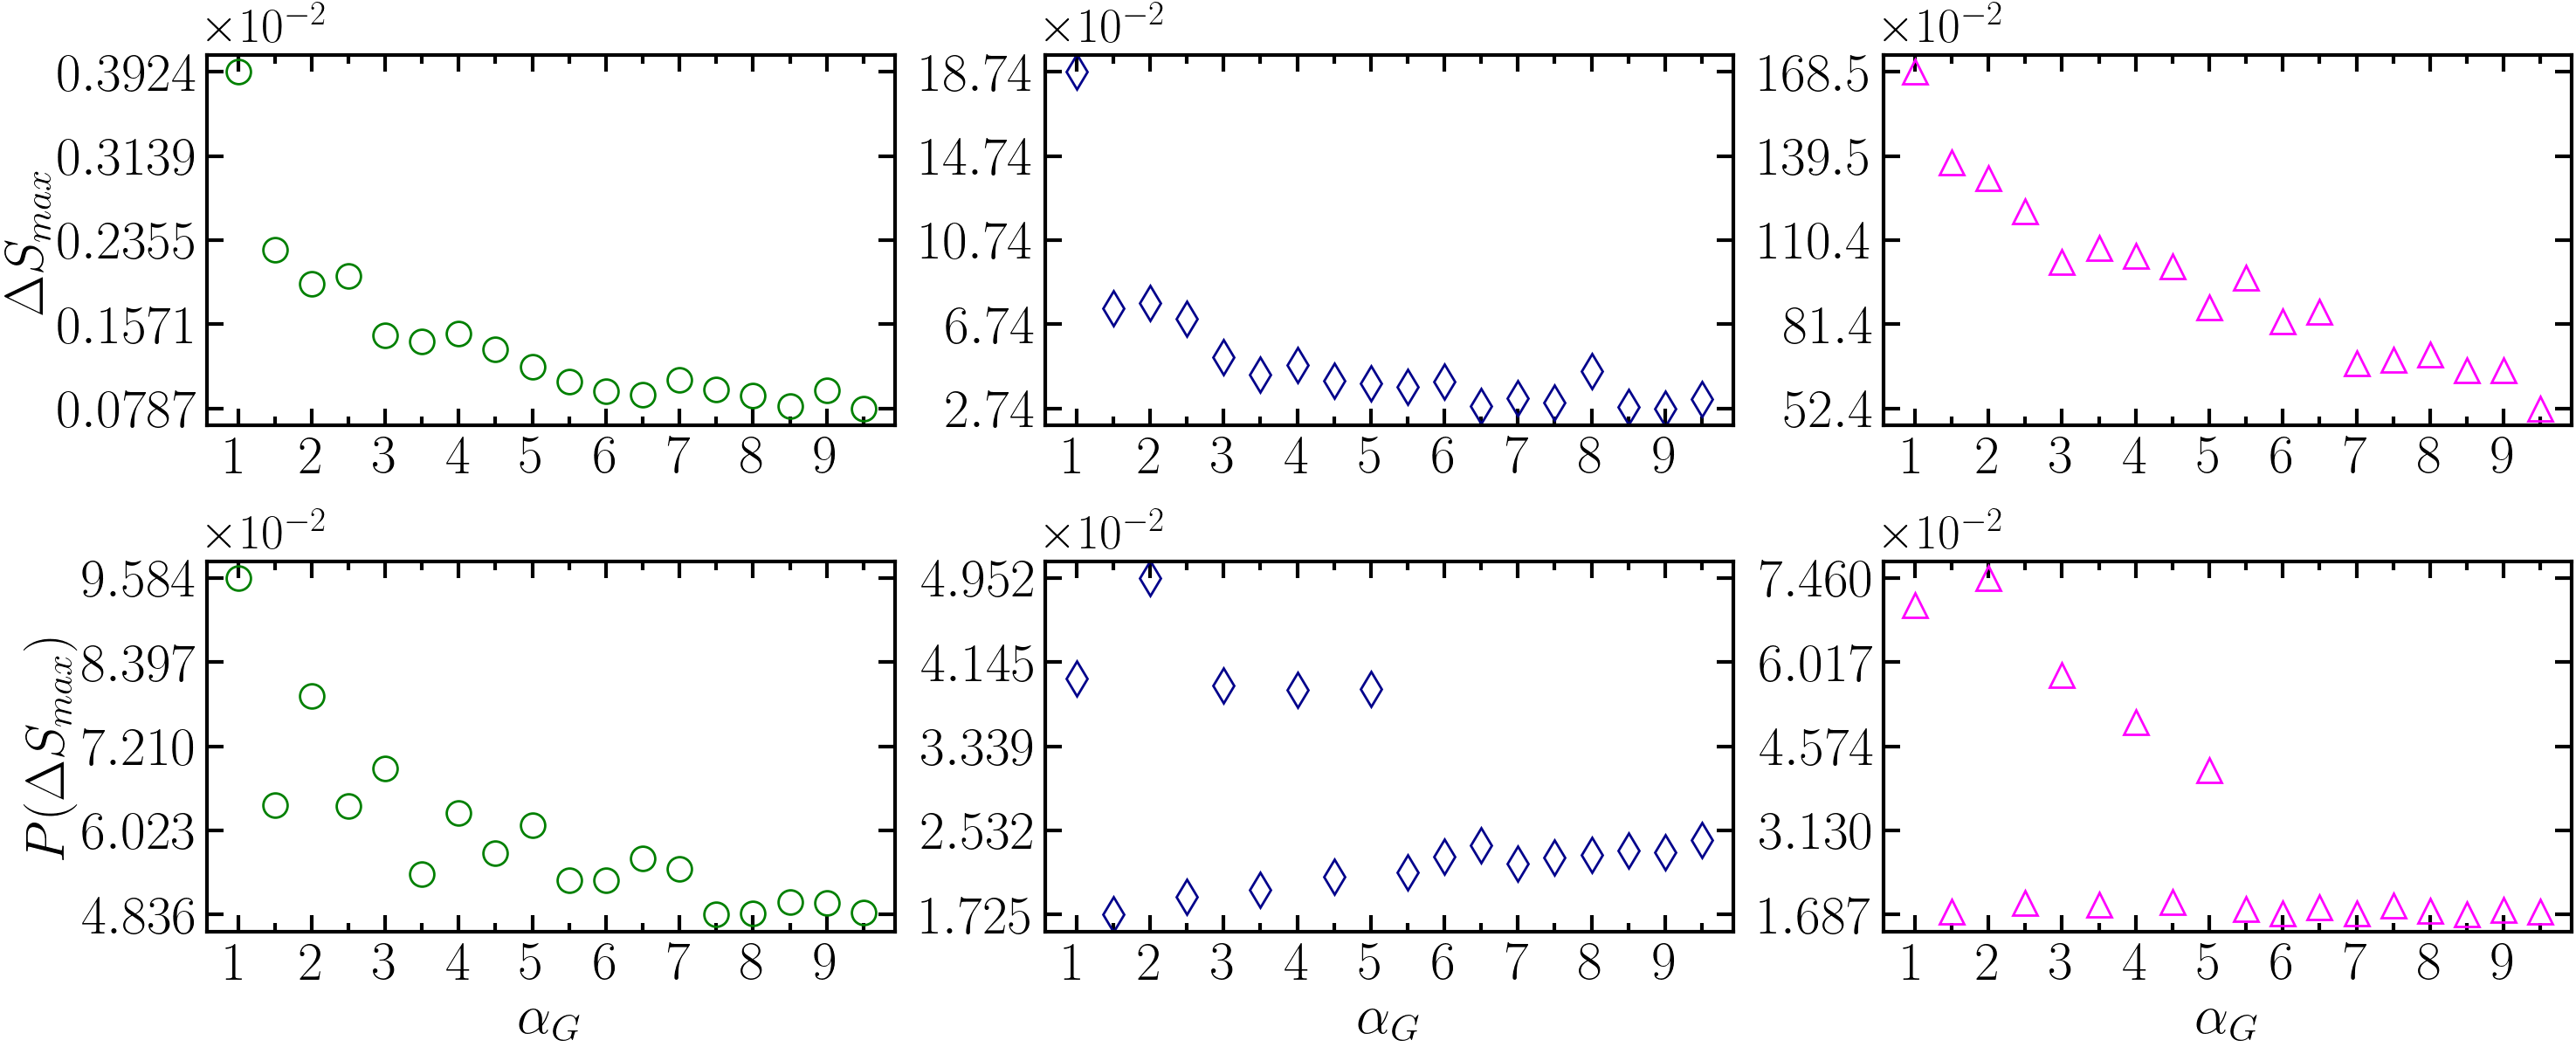

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, ScalarFormatter

dimensions = [2, 3, 4]

# Parâmetros de estilo
markersize = 20
fonts_size = 45
thickness_axes = 3.0
mew = 2.0
color = ['#008000', "#00008B", "magenta", "darkgoldenrod"]
markers = ["o", "d", "^", "s", "D"]

# Fator de escala para o eixo y
scale_factor = 1e2
scale_label = r"$\times 10^{-2}$"

# Criação dos subplots
fig, axs = plt.subplots(2, 3, figsize=(30, 12.5))  # 2 linhas, 3 colunas

# Linha superior: ΔS_max vs α_A
for i, d in enumerate(dimensions):
    ax = axs[0, i]
    x_data = np.array(df_k_max_alpha_g["alpha_g"])
    y_data = np.array(df_k_max_alpha_g[f"k_{d}d"]) * scale_factor

    ax.plot(x_data, y_data,
            markers[i], color=color[i], markerfacecolor='None',
            markersize=markersize, mew=mew)

    #ax.set_xlabel(r"$\alpha_G$", fontsize=fonts_size)
    if i == 0:
        ax.set_ylabel(r"$\Delta S_{max}$", fontsize=fonts_size)

    y_min, y_max = y_data.min(), y_data.max()
    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.annotate(scale_label, xy=(0.0, 1.02), xycoords='axes fraction',
                fontsize=fonts_size * 0.9, ha='left', va='bottom')

    ax.tick_params(axis='both', which='major', direction='in', length=14,
                   width=thickness_axes, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=7,
                   width=thickness_axes, colors='black')
    ax.tick_params('both', labelsize=fonts_size)
    ax.yaxis.offsetText.set_fontsize(fonts_size)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    for spine in ax.spines.values():
        spine.set_linewidth(thickness_axes)

# Linha inferior: P(ΔS_max) vs α_G
for i, d in enumerate(dimensions):
    ax = axs[1, i]
    x_data = np.array(df_pk_max_alpha_g["alpha_g"])
    y_data = np.array(df_pk_max_alpha_g[f"pk_{d}d"]) * scale_factor

    ax.plot(x_data, y_data,
            markers[i], color=color[i], markerfacecolor='None',
            markersize=markersize, mew=mew)

    ax.set_xlabel(r"$\alpha_G$", fontsize=fonts_size)
    if i == 0:
        ax.set_ylabel(r"$P (\Delta S_{max})$", fontsize=fonts_size)

    y_min, y_max = y_data.min(), y_data.max()
    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.annotate(scale_label, xy=(0.0, 1.02), xycoords='axes fraction',
                fontsize=fonts_size * 0.9, ha='left', va='bottom')

    ax.tick_params(axis='both', which='major', direction='in', length=14,
                   width=thickness_axes, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=7,
                   width=thickness_axes, colors='black')
    ax.tick_params('both', labelsize=fonts_size)
    ax.yaxis.offsetText.set_fontsize(fonts_size)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    for spine in ax.spines.values():
        spine.set_linewidth(thickness_axes)

# Ajuste de layout e salvamento
plt.tight_layout()
plt.savefig("../../results/distributions/max_prob_dist_alpha_g.png", dpi=300)
plt.show()


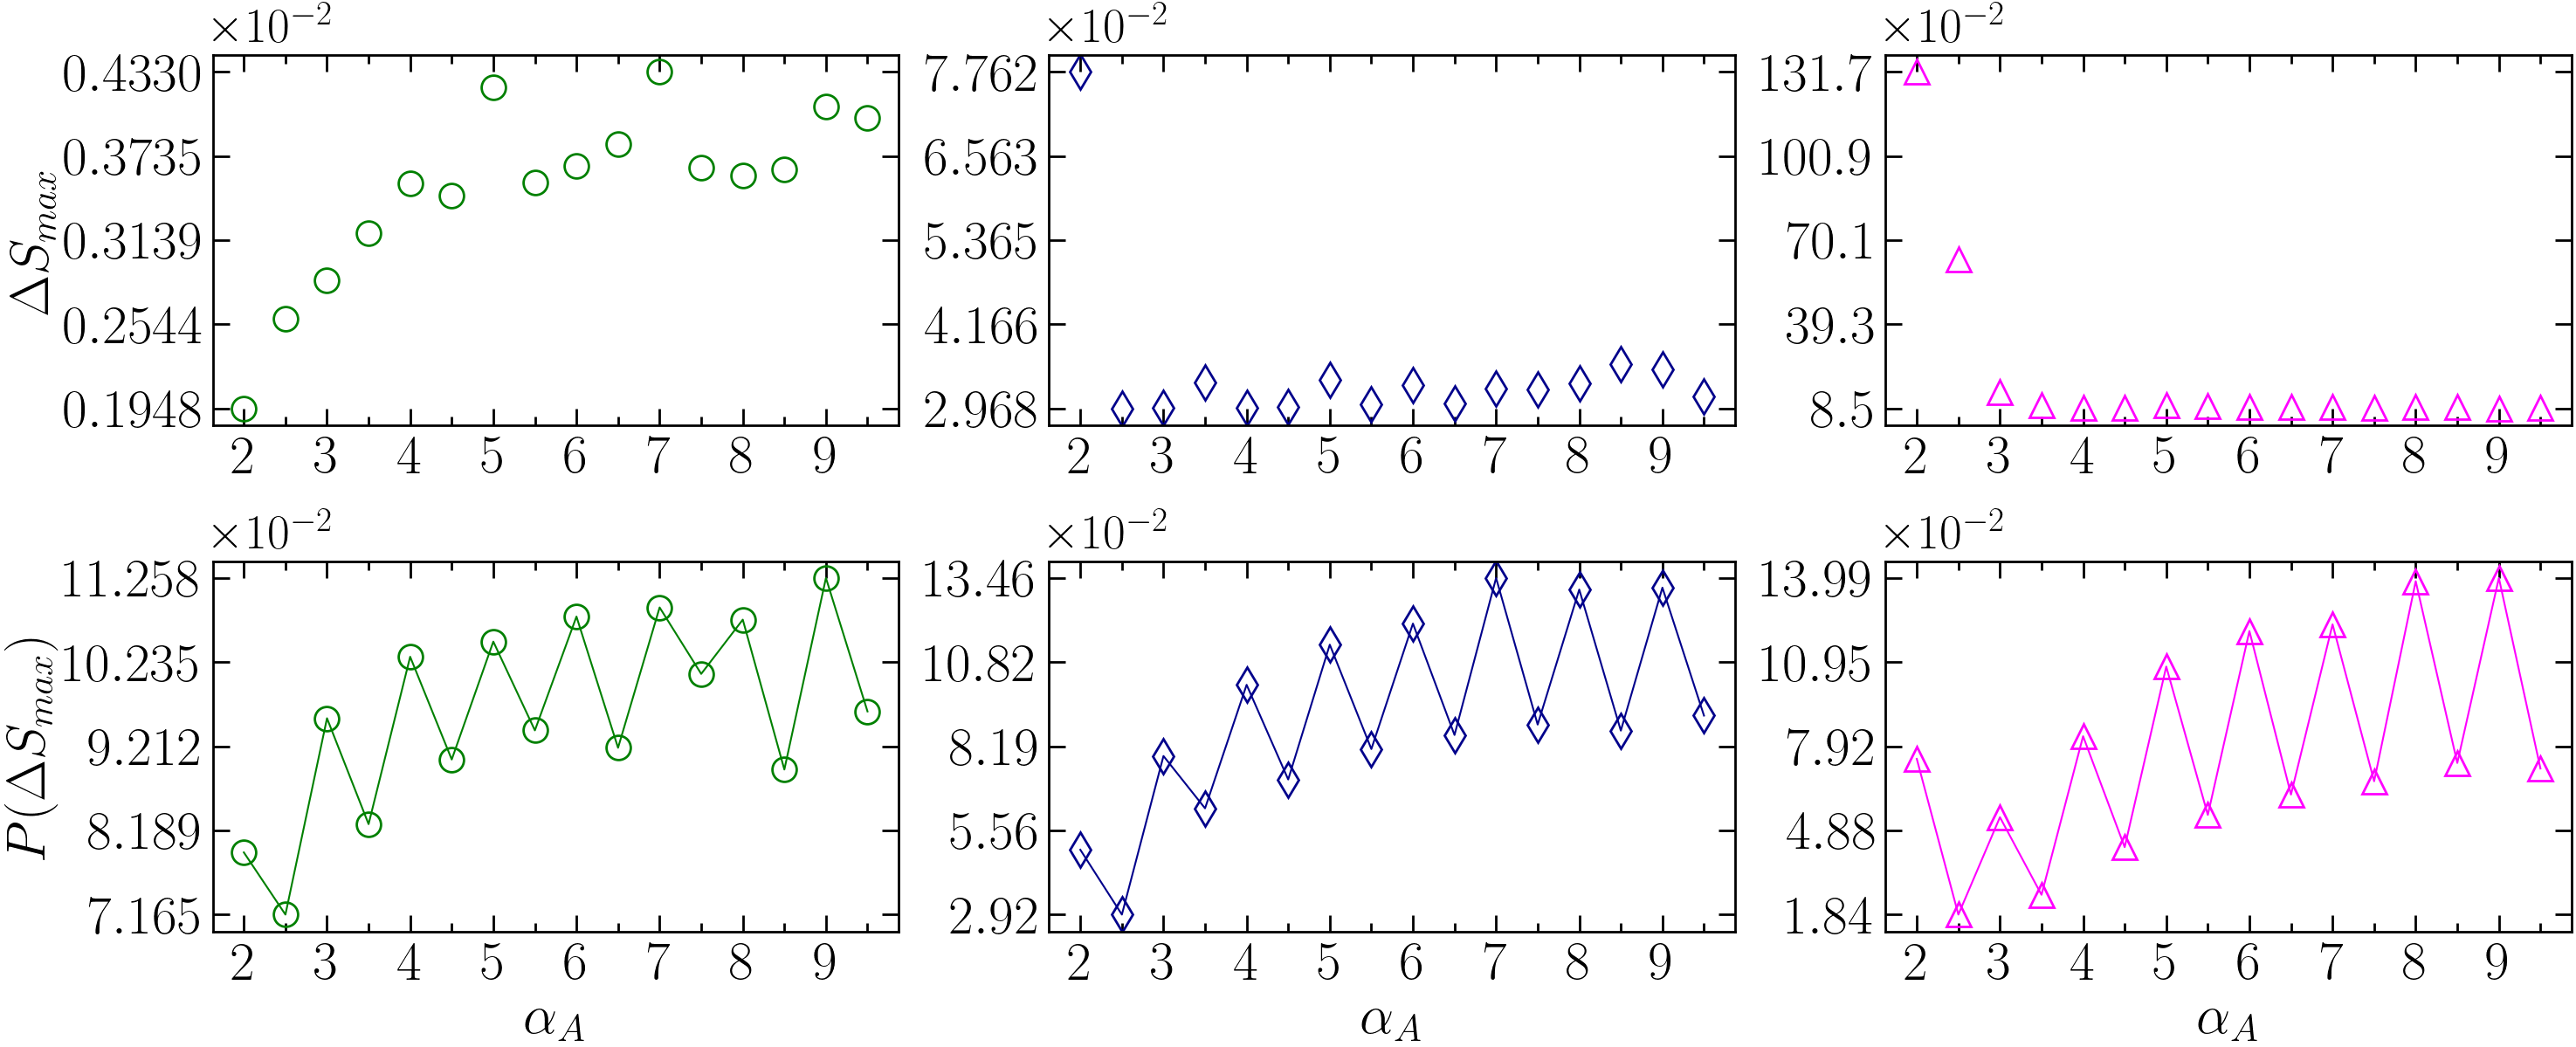

In [9]:
dimensions = [2, 3, 4]

# Parâmetros de estilo
markersize = 20
fonts_size = 45
thickness_axes = 2.0
mew = 2.0
color = ['#008000', "#00008B", "magenta", "darkgoldenrod"]
markers = ["o", "d", "^", "s", "D"]

# Fator de escala
scale_factor = 1e2
scale_label = r"$\times 10^{-2}$"

# Criação dos subplots
fig, axs = plt.subplots(2, 3, figsize=(30, 12.5))  # 2 linhas, 3 colunas

# Linha superior: ΔS_max vs α_A
for i, d in enumerate(dimensions):
    ax = axs[0, i]
    x_data = np.array(df_k_max_alpha_a["alpha_a"])
    y_data = np.array(df_k_max_alpha_a[f"k_{d}d"]) * scale_factor

    ax.plot(x_data, y_data,
            markers[i], color=color[i], markerfacecolor='None',
            markersize=markersize, mew=mew)

    #ax.set_xlabel(r"$\alpha_A$", fontsize=fonts_size)
    if i == 0:
        ax.set_ylabel(r"$\Delta S_{max}$", fontsize=fonts_size)

    y_min, y_max = y_data.min(), y_data.max()
    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.annotate(scale_label, xy=(0.0, 1.02), xycoords='axes fraction',
                fontsize=fonts_size * 0.9, ha='left', va='bottom')
    ax.yaxis.offsetText.set_fontsize(fonts_size)

    ax.tick_params(width=thickness_axes, length=10, labelsize=fonts_size)
    ax.tick_params(axis='both', which='major', direction='in', length=14,
                   width=thickness_axes, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=7,
                   width=thickness_axes, colors='black')
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    for spine in ax.spines.values():
        spine.set_linewidth(thickness_axes)

# Linha inferior: P(ΔS_max) vs α_A
for i, d in enumerate(dimensions):
    ax = axs[1, i]
    x_data = np.array(df_pk_max_alpha_a["alpha_a"])
    y_data = np.array(df_pk_max_alpha_a[f"pk_{d}d"]) * scale_factor

    ax.plot(x_data, y_data,
            markers[i], color=color[i], markerfacecolor='None',
            markersize=markersize, linestyle='-' ,mew=mew)

    ax.set_xlabel(r"$\alpha_A$", fontsize=fonts_size)
    if i == 0:
        ax.set_ylabel(r"$P (\Delta S_{max})$", fontsize=fonts_size)

    y_min, y_max = y_data.min(), y_data.max()
    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.annotate(scale_label, xy=(0.0, 1.02), xycoords='axes fraction',
                fontsize=fonts_size * 0.9, ha='left', va='bottom')
    ax.yaxis.offsetText.set_fontsize(fonts_size)

    ax.tick_params(width=thickness_axes, length=10, labelsize=fonts_size)
    ax.tick_params(axis='both', which='major', direction='in', length=14,
                   width=thickness_axes, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=7,
                   width=thickness_axes, colors='black')
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    for spine in ax.spines.values():
        spine.set_linewidth(thickness_axes)

# Ajuste de layout e salvamento
plt.tight_layout()
plt.savefig("../../results/distributions/max_prob_dist_alpha_a.png", dpi=300)
plt.show()